In [1]:
from motion_utils import *
from ot_utils import *
from matplotlib import pyplot as plt

from skimage import io

In [2]:
normalize = lambda x : x/np.sum(x)

In [3]:
grid=(30000,30000)
frames=[30,31]
data=[thunderstorm_extract("~/year_2/optimal_transport/data/particle_positions.csv",f) for f in frames]

In [4]:
sp,si=data[0]
ep,ei=data[1]

In [5]:
n=len(si)
m=len(ei)
si=np.array(si).reshape((len(si),1))
ei=np.array(ei).reshape((1,len(ei)))

In [6]:
C=L2_cost(sp,ep)

In [7]:
epsilon=0.1
f_init=np.zeros(len(si))

In [8]:
(C-f_init[:,None]).shape

(18, 23)

In [9]:
P,Err=Sinkhorn(C,normalize(si),normalize(ei),epsilon,f_init,3000)

0.12296804318181465

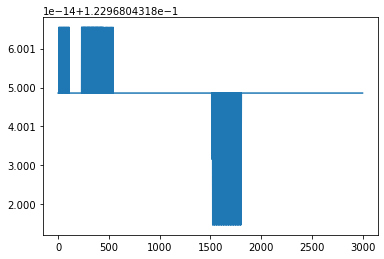

In [10]:
plt.plot(Err)
np.min(Err)

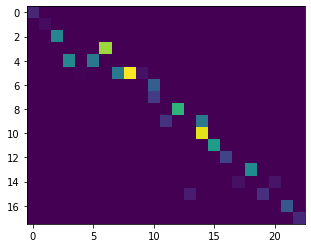

In [11]:
plt.imshow(P)

In [12]:
np.sum(si)

72285.79912320255

In [13]:
np.sum(ei)

106604.34522115838

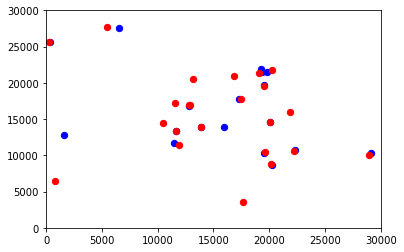

In [14]:
fig,ax=plt.subplots()

beg_x,beg_y= zip(*sp)
end_x,end_y= zip(*ep)

ax.set_xlim([0,grid[0]])
ax.set_ylim([0,grid[1]])
size_s=400*normalize(si)
size_e=400*normalize(ei)
ax.scatter(beg_x,beg_y,color='blue',s=40)
ax.scatter(end_x,end_y,color='red',s=40)

for i in range(n):
    for j in range(m):
        if (P[i,j]/si[i])>0.1:#so there is a non-neglegible transport between the two
            #print(i,j)
            xvals=[beg_x[i],end_x[j]]
            yvals=[beg_y[i],end_y[j]]
            thickness=1.8*(P[i,j]/si[i])+0.2 #scaled by what fraction of the total transport from i it is
            ax.plot(xvals,yvals,linewidth=thickness,color='black')

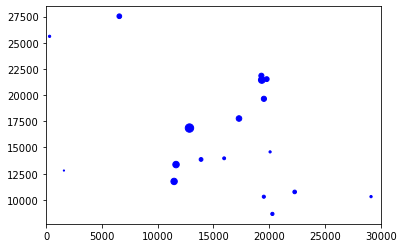

In [15]:
fig,ax=plt.subplots()
ax.set_xlim([0,grid[0]])
size_s=400*normalize(si)
ax.scatter(beg_x,beg_y,color='blue',s=size_s)

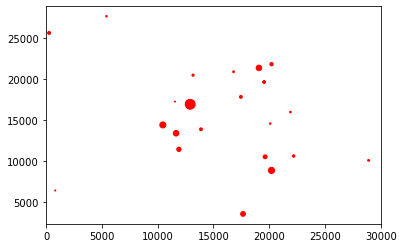

In [16]:
fig,ax=plt.subplots()
ax.set_xlim([0,grid[0]])
size_e=400*normalize(ei)
ax.scatter(end_x,end_y,color='red',s=size_e)

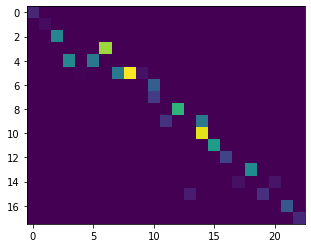

In [17]:
plt.imshow(P)

In [18]:
def sink_L2_cost(sp,ep):
    inf=1e6
    sub_cost=L2_cost(sp,ep)
    left_col=np.hstack((np.ones((len(sp),1)) * inf ,1*np.zeros((len(sp),1))))
    top_row=np.vstack((np.zeros((1,len(ep))),np.ones((1,len(ep)))*inf))
    corner=np.array([[0,0],[inf,0]])
    top=np.hstack((corner,top_row))
    bottom=np.hstack((left_col,sub_cost))
    end_cost=np.vstack((top,bottom))

    return end_cost/np.average(end_cost)

In [19]:
new_C=sink_L2_cost(sp,ep)

In [34]:
def sink_intensity_update(si,ei):#I'm not sure how to pick the amount of flow allowed along these edges
    new_si=np.append(np.array([20000,0]),si.flatten()).reshape((si.size+2,1))
    new_ei=np.append(np.array([0,20000]),ei.flatten()).reshape((1,ei.size+2))
    return new_si,new_ei

In [35]:
new_si,new_ei=sink_intensity_update(si,ei)
new_si=normalize(new_si)
new_ei=normalize(new_ei)

In [36]:
epsilon=0.1
f_init=np.zeros(len(new_si))

In [37]:
P,Err=Sinkhorn(new_C,new_si,new_ei,epsilon,f_init,4000)

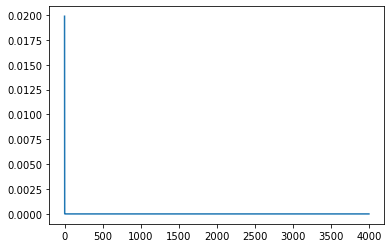

In [38]:
plt.plot(Err)

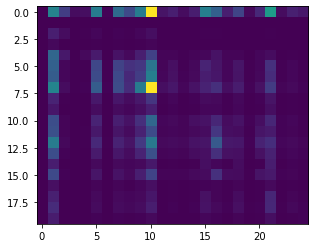

In [39]:
plt.imshow(P)

In [44]:
created=[]
for idx,transport in enumerate(P[0]):
    if transport>0.3*new_ei[0][idx]:
        created+=[idx-2]#accounting for the additional 2 entries
print(created)

[0, 1, 2, 13, 22]


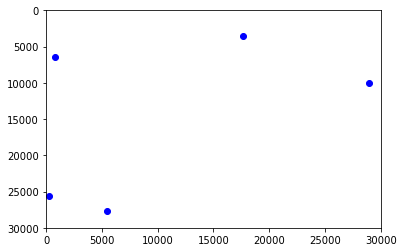

In [49]:
fig,ax=plt.subplots()

ax.set_xlim([0,grid[0]])
ax.set_ylim([0,grid[1]])

fig.gca().invert_yaxis()

for i in created:
    ax.scatter(ep[i][0],ep[i][1],color='blue')

In [43]:
removed=[]

for idx,transport in enumerate(P.transpose()[1]):
    if transport>0.3*new_si[idx][0]:
        removed+=[idx-2]#accounting for the additional 2 entries
print(removed)

[0, 2, 17]


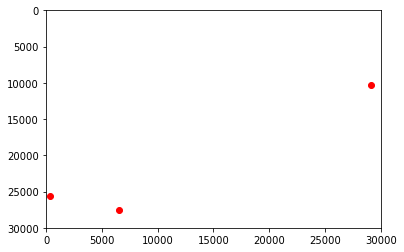

In [48]:
fig,ax=plt.subplots()

ax.set_xlim([0,grid[0]])
ax.set_ylim([0,grid[1]])
fig.gca().invert_yaxis()


for i in removed:
    ax.scatter(sp[i][0],sp[i][1],color='red')

We need to improve the plotting to make any sense of this

In [29]:
path='../data/r2_SuH_exp_50_ext_20_1-Crop1-2000.tif'#relative path only it seems
images=io.imread(path)

In [30]:
s_img=images[frames[0]-1]
e_img=images[frames[1]-1]

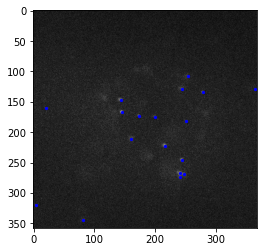

In [31]:
fig,ax=plt.subplots()

scale=80# 1px is 80nm

ax.imshow(s_img,cmap='Greys_r')
s_img.shape

beg_x,beg_y= zip(*sp)
end_x,end_y= zip(*ep)

size_s=100*normalize(si)
ax.scatter(np.array(beg_x)/scale,np.array(beg_y)/scale,color='blue',s=5)


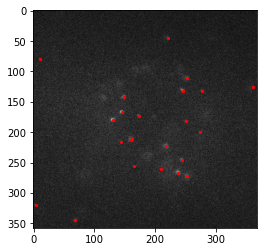

In [32]:
fig,ax=plt.subplots()

scale=80# 1px is 80nm

ax.imshow(e_img,cmap='Greys_r')
e_img.shape

end_x,end_y= zip(*ep)

size_e=100*normalize(ei)
ax.scatter(np.array(end_x)/scale,np.array(end_y)/scale,color='red',s=5)


In [33]:
np.max(ei)

25830.23112132812